# Третья часть работы по оптимизации классификации заявок на оплату для сервиса Repetit.ru

В этой тетрадке произведены следующие действия:
- столбцы purpose и add_info разбиты на кластеры, используя методы TfidfVectorizer и KMeans 
- преобразован столбец source_id согласно информации от заказчика
- определен target
- обработаны дубликаты по столбцам id и original_order_id, учитывая предмет заявки
- объединены таблицы с информацией об учителях и заказах
- произведена очистка от выпадающих значений
- созданы категориальные признаки для возраста преподавателей, опыта и цены
- изучена корреляция признаков
- подобраны гиперпараметры и обучена модель CatBoostC
- модель проверена на тестовой выборке
- произведена рекалибровка модели
- модель проверена на адекватность, а также изучена важность признаков

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import requests
from tqdm import tqdm
from nltk.cluster import KMeansClusterer
import nltk
import numpy as np
from sklearn.cluster import KMeans 
from sklearn import cluster
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import Pool, CatBoostClassifier
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Откроем файл эмбеддингами для столбца add_info и purpose

In [3]:
try:
    emb_add = pd.read_feather('Repetit/add_clust.feather')
except:
    emb_add = pd.read_feather('needed/add_clust.feather')  

### Разобьем столбец purpose_new на кластеры, используя методы TfidfVectorizer и KMeans 

In [4]:
#emb_add.head()

In [5]:
X = TfidfVectorizer().fit_transform(emb_add.purpose_new)
km = KMeans(n_clusters=15, max_iter = 100).fit(X)
list_pclust = km.labels_.tolist()

In [6]:
emb_add['purpose_cluster_tfidf'] = list_pclust
#add_info_new1['purpose_cluster_IDF'].value_counts()
#add_info_new1.to_csv('purpose_clidf.csv', index=False)

In [7]:
tqdm.pandas(desc="progress")

In [8]:
X1 = TfidfVectorizer().fit_transform(emb_add.add_info_new)
km1 = KMeans(n_clusters=15, max_iter = 100).fit(X1)
list_pclust1 = km1.labels_.tolist()    

In [9]:
emb_add['add_info_tfidf'] = list_pclust1

In [10]:
emb_add2 = emb_add

### Преобразуем столбец source_id

Заявки source_id № 2,3,4,9,13,16,24 созданы консультантами, присвоим им значение 2,  14 - дубль мог быть и консультантом и клиентом (присвоим значение 3). Остальные - клиентами (присвоим значение 1)

In [11]:
#source_id_cons = [2, 3, 4, 9, 13, 16, 24]

In [12]:
emb_add2.loc[(emb_add2['source_id'] == 2) & (emb_add2['source_id'] == 3) & (emb_add2['source_id'] == 4) & (emb_add2['source_id'] == 9)
& (emb_add2['source_id'] == 13) & (emb_add2['source_id'] == 16) & (emb_add2['source_id'] == 24), ['source_id']] = 2

In [13]:
emb_add2.loc[(emb_add2['source_id'] == 14), ['source_id']] = 3

In [14]:
emb_add2.loc[((emb_add2['source_id'] != 2) & (emb_add2['source_id'] != 3) & (emb_add2['source_id'] != 0)), ['source_id']] = 1

In [15]:
pd.set_option('display.max_columns', None)

In [16]:
emb_add2.head(5)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,status_id,planned_lesson_number,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,is_display_to_teachers,creator_id_new,purpose_new,add_info_new,add_info_dist1,number_of_messangers,student,purp_emb_cluster,add_info_emb_cluster,purpose_cluster_tfidf,add_info_tfidf
0,2294054,2022-11-01 00:01:38.237,1.0,0,0,60,NaN,0,16,0,0.0,NaN,0,0,3,0,0,0,0,0,0,0,0,1,2294000.0,675960,1,0.0,0,0,0,0,0,4,4,1,0
1,2294055,2022-11-01 00:03:11.753,1.0,0,0,60,NaN,0,7,0,0.0,NaN,0,0,3,0,0,0,0,0,0,0,0,1,2294000.0,675960,1,0.0,0,0,0,0,0,4,4,1,0
2,2294056,2022-11-01 00:04:01.563,21.0,1,800,60,NaN,1,16,7,0.0,14.0,2,0,3,0,0,4,0,0,0,0,0,1,NaN,1024439,1,0.0,разделы: начертательная геометрия. категория у...,место проведения занятий: дистанционно (наприм...,1,1,1,0,2,1,5
3,2294057,2022-11-01 00:08:47.237,8.0,1,700,60,NaN,1,16,10,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,3,2293804.0,1024340,1,2.0,разделы: школьный курс. категория ученика: шко...,место проведения занятий: дистанционно (наприм...,1,1,2,0,1,5,1
4,2294058,2022-11-01 00:11:49.417,8.0,0,0,60,122.0,0,16,0,0.0,NaN,0,0,0,0,0,2,0,0,0,0,0,1,NaN,1024440,1,0.0,0,0,0,0,0,4,4,1,0


In [17]:
emb_add2['source_id'].value_counts()

source_id
1    848791
3    334601
2      7942
0       527
Name: count, dtype: int64

### Определим столбец target и проставим оплату, если status_id 5,6,13,15

In [18]:
emb_add2['status_id'].value_counts()

status_id
16         792406
7          212816
6          121519
14          32952
8            8178
11           7202
12           4733
15           3469
3            3166
13           2111
4            1852
9            1057
5             291
1             102
2               3
3211265         2
3342337         1
3605505         1
Name: count, dtype: int64

In [19]:
for i in range(len(emb_add2['status_id'])):
    if emb_add2.loc[i, 'status_id'] == 6 or emb_add2.loc[i, 'status_id'] == 15 or emb_add2.loc[i, 'status_id'] == 13 or emb_add2.loc[i, 'status_id'] == 5:
        emb_add2.loc[i, 'target'] = 1
    else:
        emb_add2.loc[i, 'target'] = 0

Удалим столбец status_id

In [20]:
emb_add2 = emb_add2.drop(columns=['status_id'], axis=1)

### Проверим на наличие дубликатов

In [21]:
duplicates =  emb_add2.duplicated().sum()
duplicates

900

Удалим полные дубликаты

In [22]:
emb_add2 = emb_add2.drop_duplicates().reset_index(drop=True)

#### Обработаем дубликаты по столбцам id и original_order_id.

Клиент с оригинальным client_id может создать несколько заявок по разным предметам, на которые, в свою очередь, могут быть созданы дубликаты, если не подошел репетитор. Таким образом, необходимо сгруппировать данные по столбцам client_id и subject_id и по статусу оплаты, а затем удалим дубликаты.

In [23]:
emb_add2 = emb_add2.sort_values(['subject_id', 'client_id', 'target'], ascending = False).drop_duplicates(['subject_id', 'client_id'], keep='first')
emb_add2.head(5)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,planned_lesson_number,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,is_display_to_teachers,creator_id_new,purpose_new,add_info_new,add_info_dist1,number_of_messangers,student,purp_emb_cluster,add_info_emb_cluster,purpose_cluster_tfidf,add_info_tfidf,target
1190960,3605505,0029-07-18 05:28:02.684,3605505.0,0,3605505,3605505,3605505.0,0,3605505,3605505.0,3605505.0,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,1,1,1,3605505.0,3605505,1,1.0,0,0,0,0,0,4,4,1,0,0.0
325999,3342337,0042-01-12 04:26:08.039,3342337.0,0,3342337,3342337,3342337.0,0,3342337,3342337.0,3342337.0,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,1,1,1,3342337.0,3342337,1,1.0,0,0,0,0,0,4,4,1,0,0.0
105390,3211265,0042-01-12 05:09:05.007,3211265.0,0,3211265,3211265,3211265.0,0,3211265,3211265.0,3211265.0,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,1,1,1,3211265.0,3211265,1,1.0,0,0,0,0,0,4,4,1,0,0.0
753580,2936522,2023-11-05 21:21:46.550,36.0,1,5000,60,NaN,1,10,0.0,5.0,3,0,3,0,0,4,0,0,0,0,0,1,NaN,1268555,1,0.0,разделы: гимнастика. категория ученика: 4 класс.,"желаемое время для занятий: воскресенье - 10, ...",0,0,0,0,2,1,9,0.0
753477,2936419,2023-11-05 20:04:36.813,36.0,1,500,60,1658.0,1,10,0.0,10.0,3,0,2,0,0,2,0,0,0,0,1,1,NaN,1268514,1,0.0,"разделы: конный спорт, фигурное катание. катег...",как далеко могу ехать к репетитору: в любой ра...,2,0,0,2,2,1,13,0.0


#### Удалим  столбцы order_date как неинформативный.

In [24]:
emb_add2 = emb_add2.drop(columns=['order_date'], axis=1)

In [25]:
emb_add2 = emb_add2.fillna(0)

## Откроем готовую после обработки таблицу с данными об преподавателях

In [26]:
teachers = pd.read_csv('teachers_ready.csv')

In [27]:
teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676717 entries, 0 to 676716
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   676717 non-null  int64  
 1   is_home_lessons      676717 non-null  int64  
 2   is_external_lessons  676717 non-null  int64  
 3   lesson_duration      676717 non-null  float64
 4   lesson_cost          676717 non-null  float64
 5   rating               676717 non-null  float64
 6   sex                  676717 non-null  float64
 7   is_remote_lessons    676717 non-null  int64  
 8   rating_for_users     676717 non-null  float64
 9   review_num           676717 non-null  float64
 10  age                  676717 non-null  float64
 11  expirience           676717 non-null  float64
 12  assign               676717 non-null  int64  
 13  contact_result_new   676717 non-null  int64  
 14  working_teacher_id   676717 non-null  int64  
dtypes: float64(8), in

### Обединим таблицы с информацией об учителях и заказах

In [28]:
ready = emb_add2.merge(teachers, on='id', how='left')
ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579847 entries, 0 to 579846
Data columns (total 50 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       579847 non-null  int32  
 1   subject_id               579847 non-null  float32
 2   purpose                  579847 non-null  int64  
 3   lesson_price             579847 non-null  int32  
 4   lesson_duration_x        579847 non-null  int32  
 5   home_metro_id            579847 non-null  float32
 6   add_info                 579847 non-null  int64  
 7   planned_lesson_number    579847 non-null  int32  
 8   creator_id               579847 non-null  float32
 9   pupil_category_new_id    579847 non-null  float32
 10  lessons_per_week         579847 non-null  int32  
 11  minimal_price            579847 non-null  int32  
 12  teacher_sex              579847 non-null  int32  
 13  teacher_experience_from  579847 non-null  int32  
 14  teac

Типы данных соответствуют

Заполним пропуски в данных

In [29]:
ready = ready.fillna(0)

In [30]:
pd.options.display.float_format = '{:,.2f}'.format

### Избавимся от выпадающих значений

В столбцах teacher_age_from и teacher_age_to есть отрицательные значения, заменим их vjlektv

In [31]:
ready.loc[:,['teacher_age_from', 'teacher_age_to', 'rating']] = ready.loc[:,['teacher_age_from', 'teacher_age_to', 'rating']].abs()

In [32]:
ready.describe()

,id,subject_id,purpose,lesson_price,lesson_duration_x,home_metro_id,add_info,planned_lesson_number,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,is_display_to_teachers,creator_id_new,add_info_dist1,number_of_messangers,student,purp_emb_cluster,add_info_emb_cluster,purpose_cluster_tfidf,add_info_tfidf,target,is_home_lessons,is_external_lessons,lesson_duration_y,lesson_cost,rating,sex,is_remote_lessons,rating_for_users,review_num,age,expirience,assign,contact_result_new,working_teacher_id
count,"579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00","579,847.00"
mean,"2,344,313.28",28.08,0.91,"2,916.75",78.08,527.69,0.93,26.32,"119,820.06",26.55,20.72,210.54,19.79,19.02,18.10,20.40,17.92,26.02,34.97,0.03,0.14,1.14,"251,467.94","984,380.36",0.97,0.31,1.23,0.30,1.43,1.44,1.04,4.50,5.85,0.21,5.75,5.75,14.26,170.73,41.98,4.12,5.75,46.23,0.40,8.17,5.01,5.75,0.47,5.75
std,"343,215.87","7,711.58",0.28,"1,313,629.52","7,711.49","7,727.07",0.26,"7,711.60","303,096.62","7,711.58","7,711.61","7,885.79","7,711.62","7,711.62","7,711.62","7,711.62","7,711.62","7,711.61","7,712.77",0.17,0.34,0.51,"732,245.50","204,590.82",0.18,0.68,0.99,0.46,1.14,1.32,1.21,3.69,4.50,0.41,12.26,12.26,21.72,321.12,"1,477.85",9.54,12.26,189.41,2.17,12.98,11.95,12.26,0.54,12.26
min,"1,742,637.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"2,047,830.00",4.00,1.00,600.00,60.00,0.00,1.00,10.00,0.00,6.00,3.00,0.00,2.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,"887,016.50",1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"2,357,579.00",8.00,1.00,900.00,60.00,205.00,1.00,10.00,0.00,10.00,3.00,0.00,3.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,"1,008,930.00",1.00,0.00,1.00,0.00,2.00,1.00,1.00,4.00,5.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
75%,"2,636,315.00",14.00,1.00,"1,500.00",60.00,911.00,1.00,10.00,0.00,12.00,4.00,300.00,3.00,1.00,0.00,4.00,0.00,20.00,40.00,0.00,0.00,1.00,0.00,"1,137,434.50",1.00,0.00,2.00,1.00,2.00,2.00,2.00,7.00,9.00,0.00,4.00,4.00,25.59,262.50,0.91,3.00,4.00,29.17,0.00,14.15,7.28,4.00,1.00,4.00
max,"3,605,505.00","3,605,505.00",1.00,"1,000,000,000.00","3,605,505.00","3,605,505.00",1.00,"3,605,505.00","3,605,505.00","3,605,505.00","3,605,505.00","3,605,505.00","3,605,505.00","3,605,505.00","3,605,505.00","3,605,505.00","3,605,505.00","3,605,505.00","3,605,505.00",1.00,1.00,3.00,"3,605,505.00","3,605,505.00",1.00,2.00,3.00,4.00,7.00,4.00,4.00,14.00,14.00,1.00,211.00,211.00,999.00,"10,000.00","100,500.00",183.00,211.00,"16,544.00",139.00,104.12,124.27,211.00,11.00,211.00


#### Избавимся от выпадающих значений во всех столбцах кроме id, используя метод quantile()

In [33]:
ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579847 entries, 0 to 579846
Data columns (total 50 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       579847 non-null  int32  
 1   subject_id               579847 non-null  float32
 2   purpose                  579847 non-null  int64  
 3   lesson_price             579847 non-null  int32  
 4   lesson_duration_x        579847 non-null  int32  
 5   home_metro_id            579847 non-null  float32
 6   add_info                 579847 non-null  int64  
 7   planned_lesson_number    579847 non-null  int32  
 8   creator_id               579847 non-null  float32
 9   pupil_category_new_id    579847 non-null  float32
 10  lessons_per_week         579847 non-null  int32  
 11  minimal_price            579847 non-null  int32  
 12  teacher_sex              579847 non-null  int32  
 13  teacher_experience_from  579847 non-null  int32  
 14  teac

In [34]:
cols = ready.select_dtypes(include=np.number).columns[1:].tolist()

In [35]:
#cols

In [36]:
Q1 = ready[cols].quantile(0.05)
Q3 =ready[cols].quantile(0.95)
IQR = Q3 - Q1

ready = ready[~((ready[cols] < (Q1 - 1.5 * IQR)) |(ready[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [37]:
ready.describe()

,id,subject_id,purpose,lesson_price,lesson_duration_x,home_metro_id,add_info,planned_lesson_number,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,is_display_to_teachers,creator_id_new,add_info_dist1,number_of_messangers,student,purp_emb_cluster,add_info_emb_cluster,purpose_cluster_tfidf,add_info_tfidf,target,is_home_lessons,is_external_lessons,lesson_duration_y,lesson_cost,rating,sex,is_remote_lessons,rating_for_users,review_num,age,expirience,assign,contact_result_new,working_teacher_id
count,"482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00","482,717.00"
mean,"2,339,841.17",10.58,0.90,"1,028.74",60.00,520.65,0.91,8.65,"113,844.39",8.88,3.16,171.19,2.25,1.53,0.00,2.82,0.40,8.54,17.37,0.00,0.14,1.13,"246,238.20","986,266.79",1.00,0.30,1.20,0.28,1.40,1.49,1.10,4.50,5.66,0.19,5.35,5.35,12.22,142.11,0.74,3.70,5.35,26.30,0.19,7.07,3.51,5.35,0.45,5.35
std,"336,489.98",8.10,0.30,799.10,0.00,663.22,0.28,3.19,"294,755.62",4.58,1.52,335.54,0.96,2.80,0.00,1.73,0.83,11.92,27.85,0.00,0.35,0.49,"723,625.81","199,457.43",0.00,0.67,1.00,0.45,1.15,1.36,1.26,3.72,4.49,0.39,10.85,10.85,19.72,254.59,1.78,8.26,10.85,59.95,0.55,11.67,6.11,10.85,0.52,10.85
min,"1,742,637.00",0.00,0.00,0.00,60.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"2,053,207.00",4.00,1.00,500.00,60.00,0.00,1.00,10.00,0.00,6.00,3.00,0.00,2.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,"891,863.00",1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"2,351,333.00",8.00,1.00,900.00,60.00,212.00,1.00,10.00,0.00,10.00,3.00,0.00,3.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,"1,010,038.00",1.00,0.00,1.00,0.00,2.00,1.00,1.00,4.00,5.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
75%,"2,621,676.00",14.00,1.00,"1,500.00",60.00,932.00,1.00,10.00,0.00,12.00,4.00,300.00,3.00,2.00,0.00,4.00,0.00,20.00,45.00,0.00,0.00,1.00,0.00,"1,133,123.00",1.00,0.00,2.00,1.00,2.00,2.00,2.00,7.00,7.00,0.00,4.00,4.00,21.82,231.58,0.62,2.00,4.00,25.00,0.00,12.51,5.95,4.00,1.00,4.00
max,"2,936,683.00",36.00,1.00,"6,000.00",60.00,"2,704.00",1.00,10.00,"1,333,430.00",17.00,7.00,"2,500.00",3.00,25.00,0.00,7.00,4.00,73.00,180.00,0.00,1.00,3.00,"2,938,030.00","1,268,632.00",1.00,2.00,3.00,2.00,7.00,4.00,4.00,14.00,14.00,1.00,77.00,77.00,150.00,"1,916.67",15.00,60.00,77.00,492.17,4.64,84.49,45.95,77.00,2.00,77.00


In [38]:
ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 482717 entries, 3 to 579846
Data columns (total 50 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       482717 non-null  int32  
 1   subject_id               482717 non-null  float32
 2   purpose                  482717 non-null  int64  
 3   lesson_price             482717 non-null  int32  
 4   lesson_duration_x        482717 non-null  int32  
 5   home_metro_id            482717 non-null  float32
 6   add_info                 482717 non-null  int64  
 7   planned_lesson_number    482717 non-null  int32  
 8   creator_id               482717 non-null  float32
 9   pupil_category_new_id    482717 non-null  float32
 10  lessons_per_week         482717 non-null  int32  
 11  minimal_price            482717 non-null  int32  
 12  teacher_sex              482717 non-null  int32  
 13  teacher_experience_from  482717 non-null  int32  
 14  teacher_e

#### В датасете имеются дублирующие столбцы, касаемые оплаты занятий. Предлагаем посчитать среднее значение для столбцов 'lesson_price', 'minimal_price' в новом столбце

In [39]:
#ready.info()

In [40]:
ready['mean_price'] = abs(ready[['lesson_price', 'minimal_price']].mean(axis=1))

In [41]:
ready['mean_price'] = ready['mean_price'].fillna(0)

Создадим новый столбец с данными о разнице между 'teacher_age_to' и 'teacher_age_from'

In [42]:
ready = ready.assign(t_age=abs(ready['teacher_age_to'] - ready['teacher_age_from'])) 

In [43]:
ready.head(2)

,id,subject_id,purpose,lesson_price,lesson_duration_x,home_metro_id,add_info,planned_lesson_number,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,is_display_to_teachers,creator_id_new,purpose_new,add_info_new,add_info_dist1,number_of_messangers,student,purp_emb_cluster,add_info_emb_cluster,purpose_cluster_tfidf,add_info_tfidf,target,is_home_lessons,is_external_lessons,lesson_duration_y,lesson_cost,rating,sex,is_remote_lessons,rating_for_users,review_num,age,expirience,assign,contact_result_new,working_teacher_id,mean_price,t_age
3,2936522,36.00,1,5000,60,0.00,1,10,0.00,5.00,3,0,3,0,0,4,0,0,0,0,0,1,0.00,1268555,1,0.00,разделы: гимнастика. категория ученика: 4 класс.,"желаемое время для занятий: воскресенье - 10, ...",0,0,0,0,2,1,9,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,"2,500.00",0
4,2936419,36.00,1,500,60,"1,658.00",1,10,0.00,10.00,3,0,2,0,0,2,0,0,0,0,1,1,0.00,1268514,1,0.00,"разделы: конный спорт, фигурное катание. катег...",как далеко могу ехать к репетитору: в любой ра...,2,0,0,2,2,1,13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,250.00,0


Удалим столбцы 'teacher_age_to',  'teacher_age_from' и 'lesson_price', 'minimal_price'

In [44]:
ready = ready.drop(columns=['teacher_age_to', 'teacher_age_from', 'lesson_price', 'minimal_price'], axis=1)

#### Создадим столбец с данными о разнице 'teacher_experience_to', 'teacher_experience_from'

In [45]:
ready = ready.assign(t_exp=abs(ready['teacher_experience_to'] - ready['teacher_experience_from'])) 

In [46]:
reday = ready.drop(columns=['teacher_experience_to', 'teacher_experience_from'], axis=1)

#### Создадим корзины для столбцов mean_price, t_age, t_exp age, expirience lesson_cost, planned_lesson_number

In [47]:
col_bins = ['mean_price', 't_age', 't_exp', 'age', 'expirience', 'lesson_cost', 'planned_lesson_number']
for i in col_bins:
    ready[i+'_bin'] = pd.cut(ready[i], 4, labels=[1, 2, 3, 4], duplicates='drop')
    

In [48]:
ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 482717 entries, 3 to 579846
Data columns (total 56 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   id                         482717 non-null  int32   
 1   subject_id                 482717 non-null  float32 
 2   purpose                    482717 non-null  int64   
 3   lesson_duration_x          482717 non-null  int32   
 4   home_metro_id              482717 non-null  float32 
 5   add_info                   482717 non-null  int64   
 6   planned_lesson_number      482717 non-null  int32   
 7   creator_id                 482717 non-null  float32 
 8   pupil_category_new_id      482717 non-null  float32 
 9   lessons_per_week           482717 non-null  int32   
 10  teacher_sex                482717 non-null  int32   
 11  teacher_experience_from    482717 non-null  int32   
 12  teacher_experience_to      482717 non-null  int32   
 13  lesson_place_new   

### Изучим корреляцию признаков

#### Посчитаем корреляцию Пирсона между целевым признаком и признаками

In [49]:
plt.rcParams.update({'figure.max_open_warning': 0})

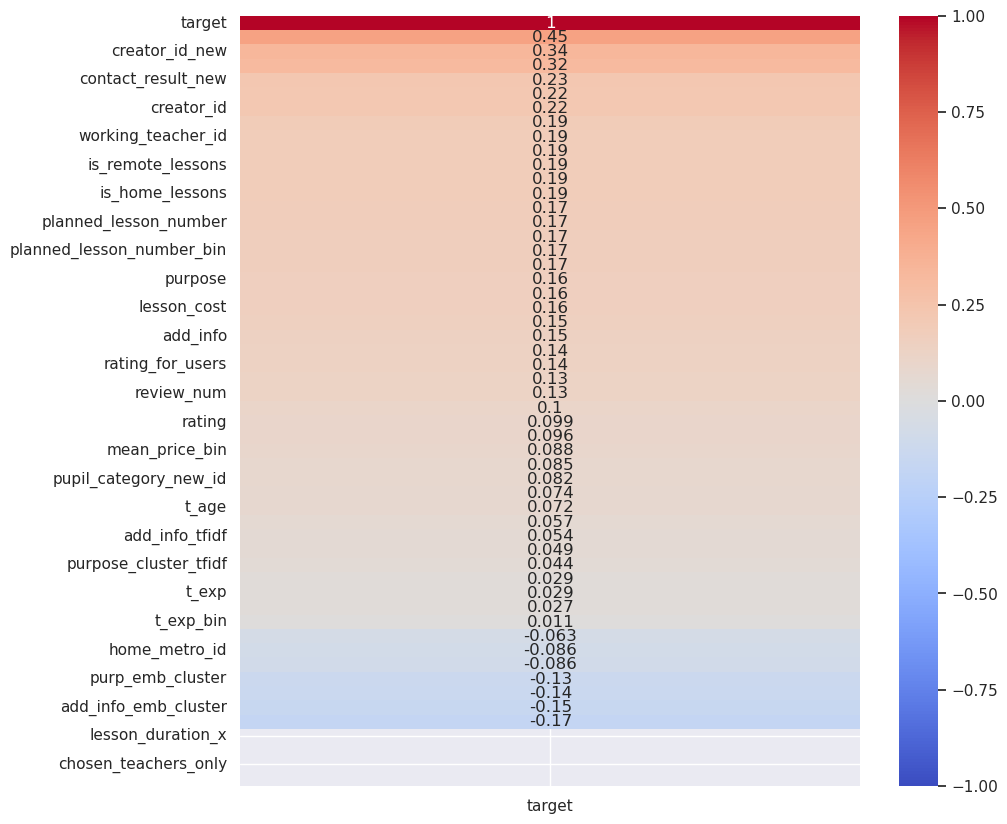

CPU times: user 6.28 s, sys: 228 ms, total: 6.5 s
Wall time: 6.26 s


In [50]:
%%time
correlation_mat = ready.select_dtypes(exclude=['object']).corr().sort_values(by = 'target', ascending = False)
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(correlation_mat[['target']], vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')
plt.show()
plt.close()

Выявлена слабая корреляция между целевым признаком и признаком source_id

#### Построим матрицу корреляции

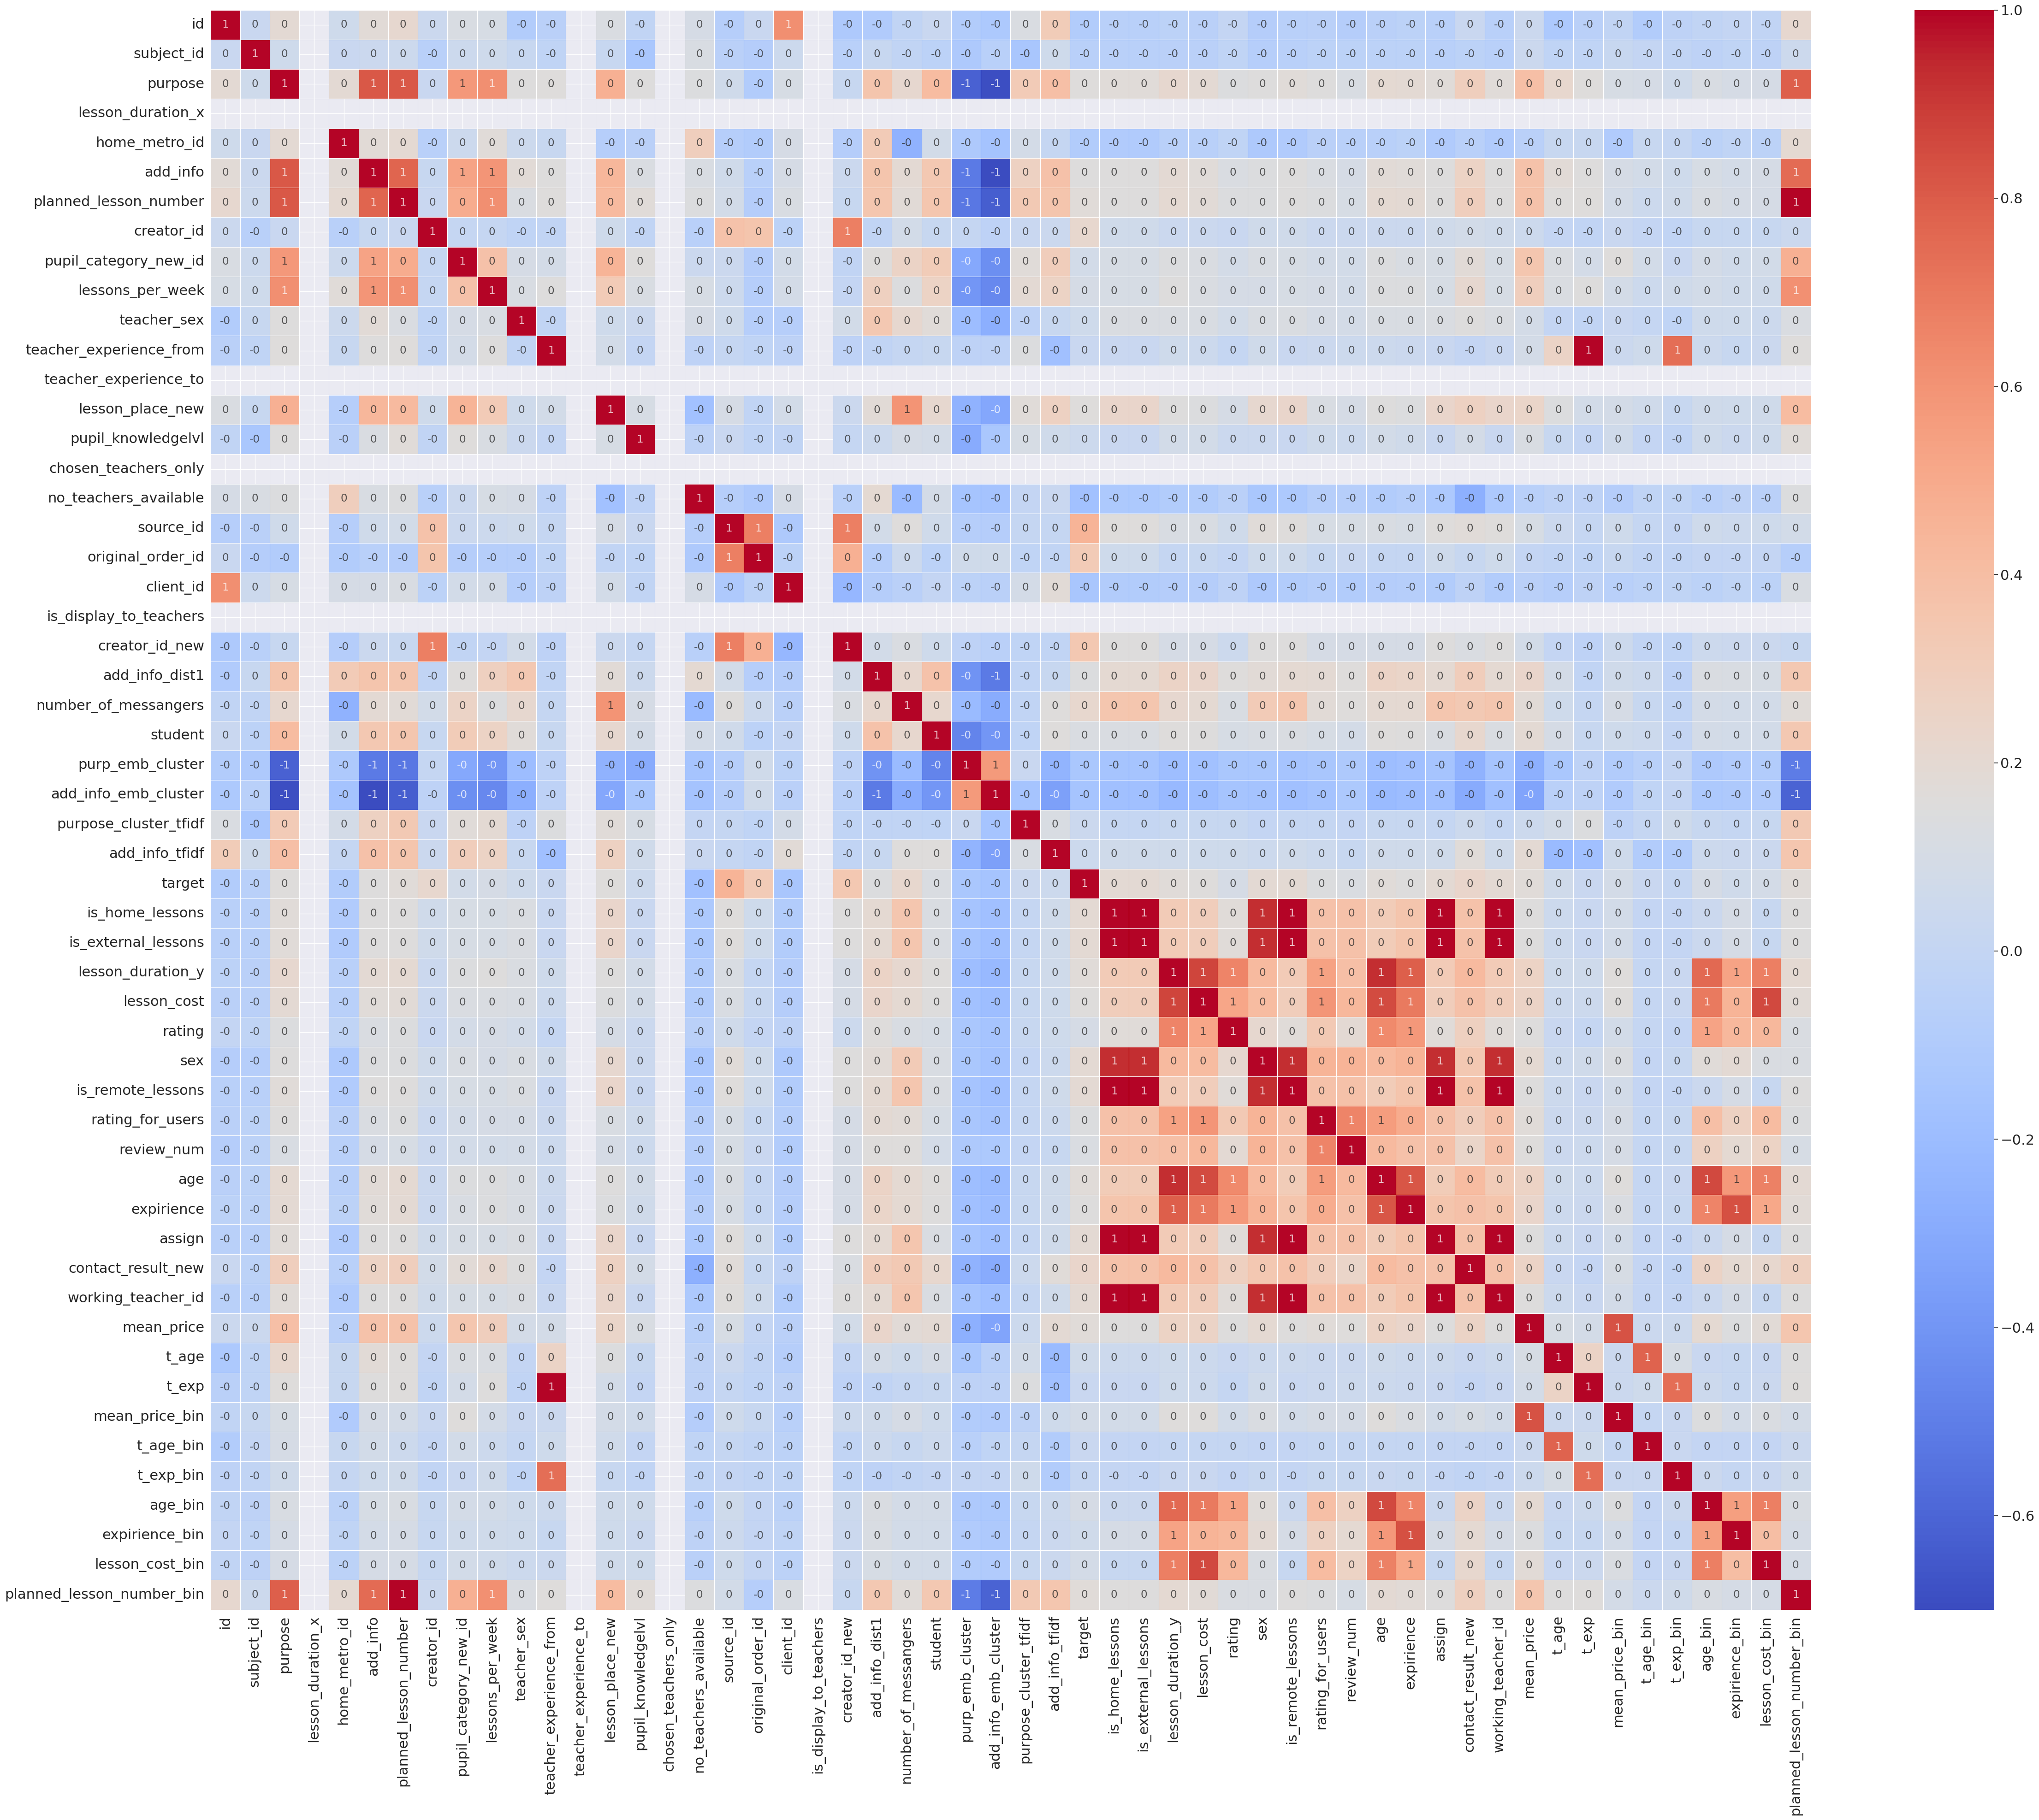

CPU times: user 19.3 s, sys: 528 ms, total: 19.8 s
Wall time: 19.3 s


In [51]:
%%time
correlation_mat = ready.select_dtypes(exclude=['object']).corr().round(2)
sns.set(rc = {'figure.figsize':(50,40)}, font_scale = 2)
sns.heatmap(correlation_mat, cmap = 'coolwarm', linewidths=.5, square=True, 
    annot_kws={'size': 'x-small', 'alpha': 0.75}, annot = True, fmt=',.0f')
plt.xticks()
plt.yticks()

plt.tight_layout()
plt.show()
plt.close('all')

# Обучение модели 

Определим столбцы с текстовыми и категориальными данными

In [52]:
text_features = ['purpose_new', 'add_info_new']
cat_features = list(ready.select_dtypes(['category']).columns)

Определим таргет, разобьем датасет на тренировочную и тестовыую выборки, учитывая дисбаланс. Определим eval_set для модели CatBoostC

In [53]:
col = ['target']
x = ready.drop(col,axis=1)
y = ready['target']

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30,random_state=12345, stratify=y)

In [55]:
list_xy = [x_train, x_test, y_train, y_test]
for i in list_xy:
    print(i.shape)

(337901, 55)
(144816, 55)
(337901,)
(144816,)


In [56]:
eval_set = (x_test, y_test)

## Подберем гиперпараметры методом GridSearchCV для модели CatBoostC

При построении модели будем указывать в параметрах лимит на использование оперативной памяти в 22GB.

In [57]:
model = CatBoostClassifier(random_state=12345, text_features = text_features, cat_features = cat_features, verbose=400,  used_ram_limit='22GB')
 
param_grid = {'iterations': [1200],
          'depth': [2],
          'auto_class_weights' : ['Balanced'],
          'l2_leaf_reg': [2],
          'leaf_estimation_iterations': [2],
          'use_best_model': [True],
          'learning_rate': [0.01],
              'early_stopping_rounds' : [200],
             'custom_metric': ['AUC' ],
              'eval_metric' : ['AUC'],
         
}
 
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, error_score='raise', verbose= False)
grid_search.fit(x_train, y_train, eval_set=eval_set)
 
# Print the best hyperparameters for Grid Search
print("Grid Search - Best Hyperparameters:", grid_search.best_params_)

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTAL

0:	test: 0.7368958	best: 0.7368958 (0)	total: 370ms	remaining: 7m 24s
400:	test: 0.8344500	best: 0.8344500 (400)	total: 1m 12s	remaining: 2m 24s
800:	test: 0.8424504	best: 0.8424504 (800)	total: 2m 23s	remaining: 1m 11s
1199:	test: 0.8460391	best: 0.8460391 (1199)	total: 3m 31s	remaining: 0us

bestTest = 0.8460391211
bestIteration = 1199

Grid Search - Best Hyperparameters: {'auto_class_weights': 'Balanced', 'custom_metric': 'AUC', 'depth': 2, 'early_stopping_rounds': 200, 'eval_metric': 'AUC', 'iterations': 1200, 'l2_leaf_reg': 2, 'leaf_estimation_iterations': 2, 'learning_rate': 0.01, 'use_best_model': True}


In [58]:
grid_search.best_score_

0.846974027677564

Лучшая метрика ROC-AUC для модели на тренировочной выборке - 0,847

In [59]:
best = grid_search.best_estimator_
best_pred_y = grid_search.predict(x_test)

### Проверим модель на тестовой выборке, а также изучим classification_report и матрицу ошибок

In [60]:
roc_auc = roc_auc_score(y_test, best_pred_y)
roc_auc

0.7480015238691097

In [61]:
print(classification_report(y_test, best_pred_y))

              precision    recall  f1-score   support

         0.0       0.93      0.72      0.81    116889
         1.0       0.40      0.77      0.53     27927

    accuracy                           0.73    144816
   macro avg       0.66      0.75      0.67    144816
weighted avg       0.83      0.73      0.76    144816



In [62]:
cm = confusion_matrix(y_test, best_pred_y, labels=grid_search.classes_)

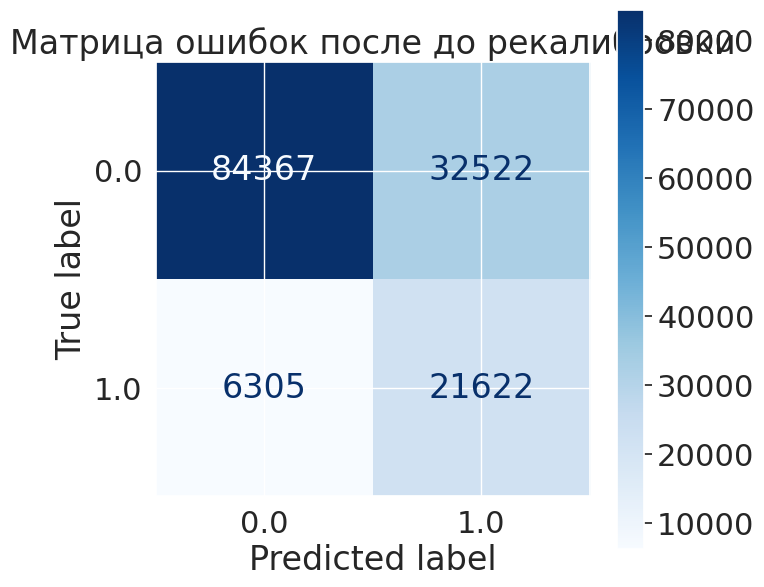

In [81]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid_search.classes_)
disp.plot(cmap='Blues')
disp.ax_.set_title("Матрица ошибок после до рекалибровки")
plt.rcParams["figure.figsize"] = (7, 7)
plt.show()
plt.close()

Cохраняем вероятности только для таргета с оплатой и рассчитываем ROC-AUC

In [64]:
grid_search.classes_

array([0., 1.])

In [65]:
probs =  grid_search.predict_proba(x_test)
probs1 = probs[:, 1]
probs_auc = roc_auc_score(y_test, probs1)
print('CatBoost: ROC AUC=%.3f' % (probs_auc))

CatBoost: ROC AUC=0.846


### Проведем рекалибровку вероятностей

In [66]:
model_cat = CalibratedClassifierCV(best, cv=3)
model_cat.fit(x_train,y_train, eval_set=eval_set)
model_cat.predict(x_test)

0:	test: 0.7368958	best: 0.7368958 (0)	total: 198ms	remaining: 3m 57s
0:	test: 0.5374505	best: 0.5374505 (0)	total: 340ms	remaining: 6m 48s
400:	test: 0.8341420	best: 0.8341420 (400)	total: 5m 2s	remaining: 10m 3s
800:	test: 0.8422107	best: 0.8422107 (800)	total: 10m 24s	remaining: 5m 11s
1199:	test: 0.8459949	best: 0.8459949 (1199)	total: 15m 27s	remaining: 0us

bestTest = 0.8459949487
bestIteration = 1199

0:	test: 0.7368958	best: 0.7368958 (0)	total: 718ms	remaining: 14m 20s
400:	test: 0.8343935	best: 0.8343935 (400)	total: 5m 18s	remaining: 10m 34s
800:	test: 0.8424528	best: 0.8424528 (800)	total: 10m 36s	remaining: 5m 17s
1199:	test: 0.8461661	best: 0.8461661 (1199)	total: 15m 32s	remaining: 0us

bestTest = 0.8461661392
bestIteration = 1199

0:	test: 0.7368958	best: 0.7368958 (0)	total: 540ms	remaining: 10m 47s
400:	test: 0.8343921	best: 0.8343921 (400)	total: 5m 16s	remaining: 10m 31s
800:	test: 0.8425050	best: 0.8425050 (800)	total: 10m 36s	remaining: 5m 16s
1199:	test: 0.846133

array([0., 0., 0., ..., 0., 0., 0.])

In [67]:
best_pred_y_calibr = model_cat.predict(x_test)

Проверим модель на тестовой выборке

In [68]:
roc_auc_calibr = roc_auc_score(y_test, best_pred_y_calibr)
roc_auc_calibr

0.662172224101657

In [69]:
print(classification_report(y_test, best_pred_y_calibr))

              precision    recall  f1-score   support

         0.0       0.86      0.97      0.92    116889
         1.0       0.77      0.35      0.48     27927

    accuracy                           0.85    144816
   macro avg       0.82      0.66      0.70    144816
weighted avg       0.84      0.85      0.83    144816



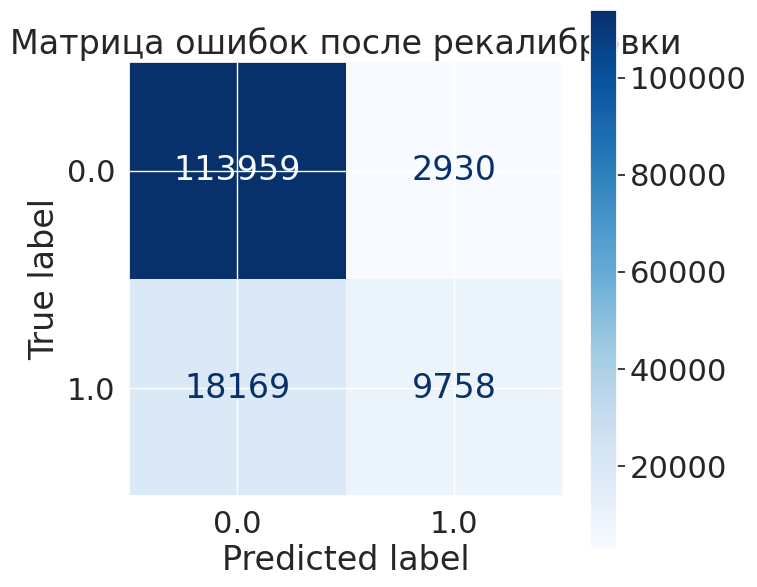

In [70]:
cm_calibr = confusion_matrix(y_test, best_pred_y_calibr, labels=model_cat.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_calibr,
                               display_labels=model_cat.classes_)
disp1.plot(cmap='Blues')
disp1.ax_.set_title("Матрица ошибок после рекалибровки")
plt.show()

Cохраняем вероятности только для таргета с оплатой и рассчитываем ROC-AUC с учетом калибровки

In [71]:
model_cat.classes_

array([0., 1.])

In [72]:
y_proba_calibr = model_cat.predict_proba(x_test)

In [73]:
y_proba_calibr = y_proba_calibr[:, 1]

In [74]:
auc_calibr = roc_auc_score(y_test, y_proba_calibr)
print('CatBoostCalibrated: ROC AUC=%.3f' % (auc_calibr))

CatBoostCalibrated: ROC AUC=0.846


## Проверим модель на адекватность

In [75]:
from sklearn.dummy import DummyClassifier

In [76]:
features_dummy = ready.drop(['target'], axis=1)
target_dummy = ready['target']

In [77]:
dummy_data = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_data.fit(features_dummy, target_dummy)

DummyClassifier(random_state=12345, strategy='most_frequent')

In [78]:
dummy_pred_y = dummy_data.predict(x_test)

In [79]:
roc_auc_dummy = roc_auc_score(y_test, dummy_pred_y)
roc_auc_dummy

0.5

## Изучим важность признаков

/tmp/ipykernel_38488/472978197.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


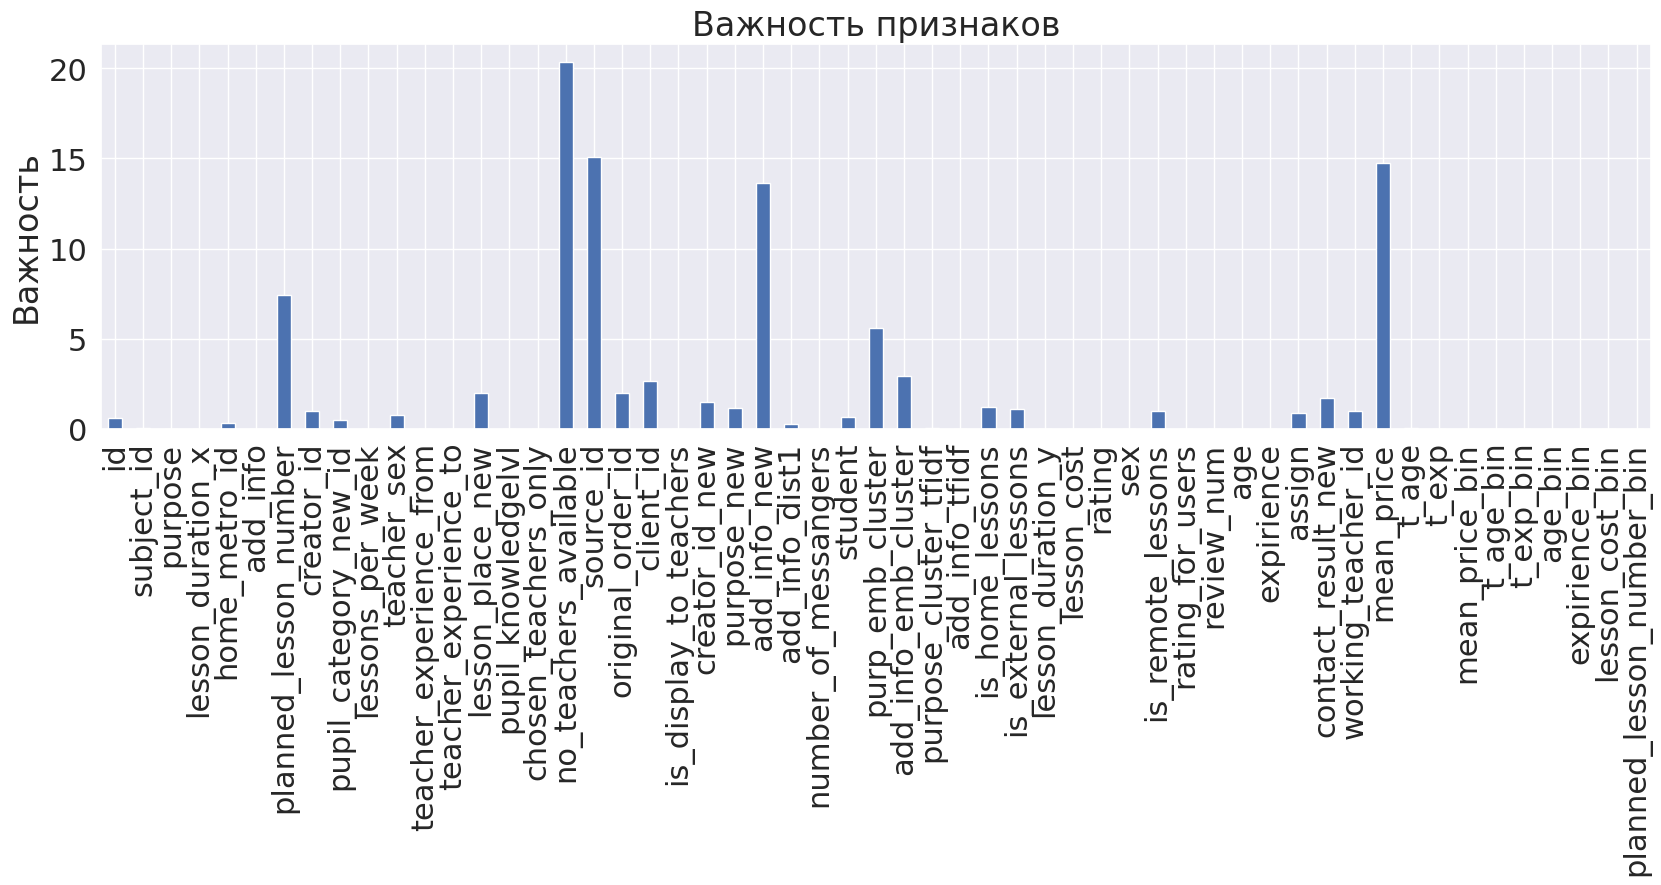

In [84]:
imp = pd.Series(grid_search.best_estimator_.feature_importances_, x_train.columns)
fig, ax = plt.subplots(figsize=(20,5))
imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

# Выводы

Нами обработаны и подготовленны данные из файлов о заказах и о преподавателях: убраны дубликаты, заполнены пропущенные значения, типы данных приведены к соответсвующим, обработаны текстовые столбцы (построены эмбеддинги, выполнена кластеризация признаков), сгенерированы искусственные фичи. Также изучена корреляция признаков.
Построена и обучена с подбором признаков и учетом дисбаланса классов модель классификации CatBoost, посчитана метрика ROC-AUC для тренироввочной и тестовой выборки (для 1 таргета - оплачено), проанализирована матрица ошибок. Модель рекалибрована и проверена на адекватность, изучены признаки, имеющие решающее значение для работы модели.

**Итоги**: модель классификации CatBoost на тестовой выборке после рекалибрации показала метрику ROC-AUC для 1 класса (оплачено) равную 0.84.

**Дополнительно**: после выполнения работы и самостоятельного код-ревью были выявлены нюансы, требющие корректировки в части оптимизации кода и выбора фичей для модели. Работа над этим будет продолжена после сдачи проекта, также как подготовка сервиса в виде Docker контейнера.